In [2]:
! pip install git+https://github.com/firekind/athena

  Cloning https://github.com/firekind/athena to /tmp/pip-req-build-2dplnw01
  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-2dplnw01
  Created wheel for athena: filename=athena-1.0.0-cp36-none-any.whl size=50819 sha256=2f705957a0a96f3b2886635cf65d1341e43f4bda8162ae09fc47c8ffc81fed12
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq2beiil/wheels/36/d3/7b/d9500a9af2498abc5d48d60c7db37c1456ee745049da352e0b
Successfully built athena


In [3]:
from athena.tuning.lr_finder import LRFinder
from athena import datasets, Experiment, Experiments, ClassificationSolver
from athena.models import DavidNet
from athena.utils.transforms import ToNumpy, ToTensor
from athena.visualizations import plot_experiments, gradcam_misclassified, plot_misclassified

import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
import cv2
import matplotlib.pyplot as plt

In [4]:
train_loader = (
    datasets.cifar10()
    .batch_size(512)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.PadIfNeeded(40, 40, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(),
        A.Cutout(num_holes=1),
        A.Lambda(ToTensor),
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(512)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = DavidNet()
criterion = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
def acc_fn(outputs, labels):
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).float()
    return correct.mean()











































Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.35E-03


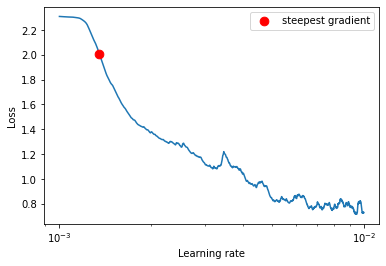

In [6]:
lr_finder = LRFinder(model, optimizer, criterion, acc_fn=acc_fn, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1e-2, num_iter=1000, step_mode="linear")
res = lr_finder.plot(skip_start=0, skip_end=0)

In [8]:
lr_val = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print("LeastLoss_BestLR", lr_val)

LeastLoss_BestLR 0.009486486486486489


In [10]:
max_lr = lr_val
min_lr = max_lr/5
print("MAX LR :",max_lr)
print("MIN LR :",min_lr)



MAX LR : 0.009486486486486489
MIN LR : 0.0018972972972972977


In [15]:
epochs = 24
exp1 = (
    Experiments.builder()
    .name("DavidNet")
    .log_directory("./logs")
    .add("max_lr=0.0094")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=min_lr, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=max_lr, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

In [16]:
exp1.run()

=> Running experiment: max_lr=0.0094
Epoch: 1 / 24
98/98 [==============================] - 97s 985ms/step - train loss: 1.8811 - train accuracy: 40.4960
Test set: Average loss: 1.3581, Accuracy: 5278/10000 (52.78%)

Epoch: 2 / 24
98/98 [==============================] - 96s 976ms/step - train loss: 1.1946 - train accuracy: 58.1320
Test set: Average loss: 1.1261, Accuracy: 6132/10000 (61.32%)

Epoch: 3 / 24
98/98 [==============================] - 96s 982ms/step - train loss: 1.0317 - train accuracy: 64.7340
Test set: Average loss: 1.2474, Accuracy: 6164/10000 (61.64%)

Epoch: 4 / 24
98/98 [==============================] - 97s 992ms/step - train loss: 1.0182 - train accuracy: 67.4500
Test set: Average loss: 1.0717, Accuracy: 6793/10000 (67.93%)

Epoch: 5 / 24
98/98 [==============================] - 98s 996ms/step - train loss: 0.7763 - train accuracy: 74.1320
Test set: Average loss: 0.7112, Accuracy: 7702/10000 (77.02%)

Epoch: 6 / 24
98/98 [==============================] - 95s 974m

In [ ]:
epochs = 24
exp1 = (
    Experiments.builder()
    .name("DavidNet")
    .log_directory("./logs")
    .add("max_lr=0.01")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=max_lr, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=max_lr, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

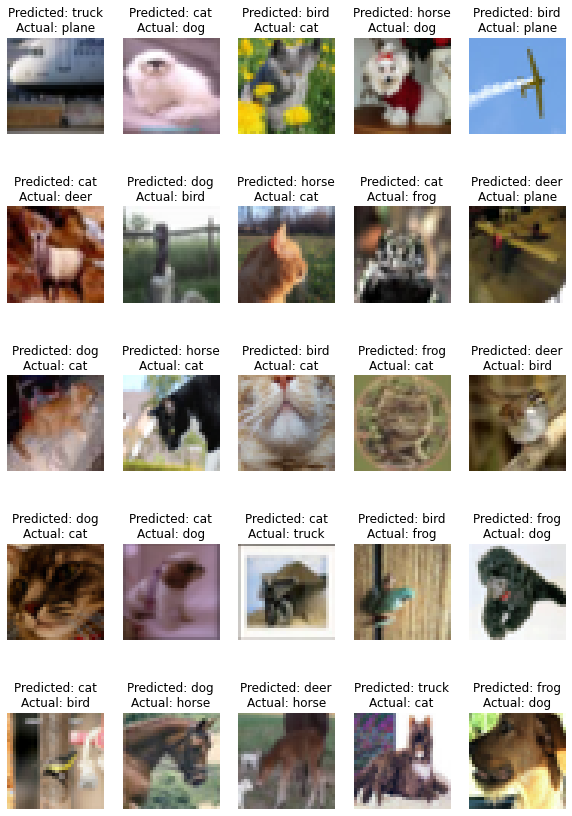

In [18]:
plot_misclassified(
    25,
    exp1["max_lr=0.0094"],
    test_loader,
    "cuda",
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std
)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


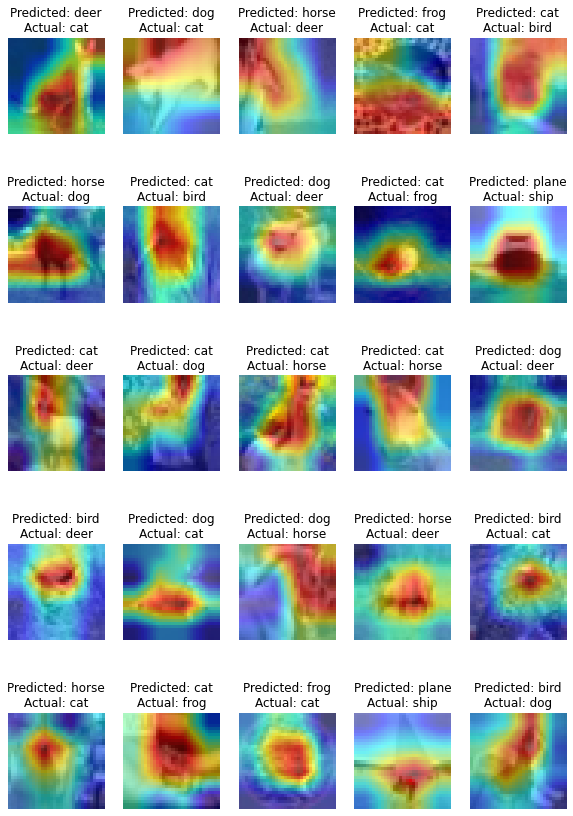

In [19]:
gradcam_misclassified(
    25,
    exp1["max_lr=0.0094"],
    exp1["max_lr=0.0094"].model.layer3,
    test_loader,
    "cuda",
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
)